In [ ]:
import zipfile
with zipfile.ZipFile('/content/archive (1) (1).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


Accuracy: 36.63%

Confusion Matrix:
 [[ 134    0   68  337  175  189   55]
 [  23    0   18   23   20   21    6]
 [  75    0  143  352  173  151  130]
 [  55    0   65 1295  126  175   58]
 [  77    0   64  401  418  190   83]
 [ 103    0   85  428  238  340   53]
 [  28    0   91  234  105   74  299]]

Classification Report:
               precision    recall  f1-score   support

       angry       0.27      0.14      0.18       958
     disgust       1.00      0.00      0.00       111
        fear       0.27      0.14      0.18      1024
       happy       0.42      0.73      0.53      1774
     neutral       0.33      0.34      0.34      1233
         sad       0.30      0.27      0.28      1247
    surprise       0.44      0.36      0.39       831

    accuracy                           0.37      7178
   macro avg       0.43      0.28      0.27      7178
weighted avg       0.35      0.37      0.34      7178



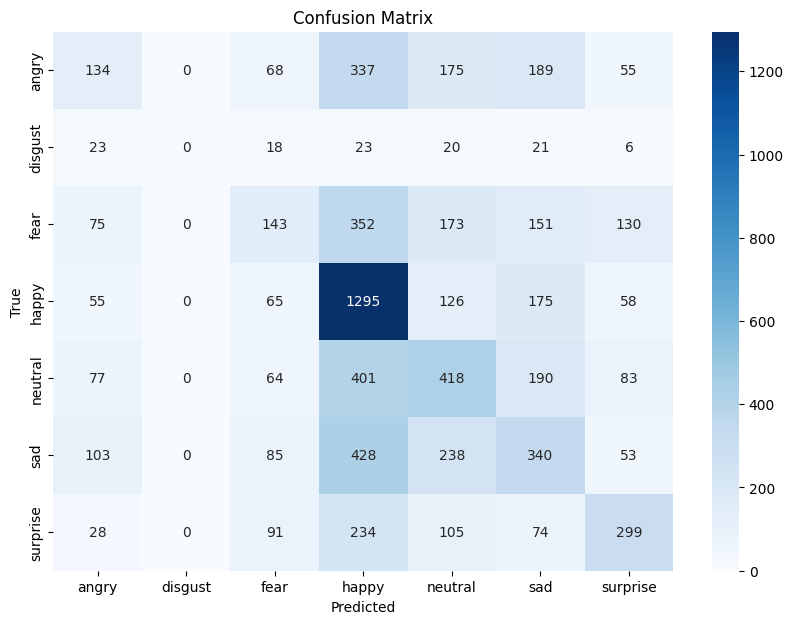

In [ ]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess dataset
def load_images_for_svm(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
            img = cv2.resize(img, (32, 32))  # Resize to 32x32 for faster processing
            if img is not None:
                # Extract HOG features
                hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
                images.append(hog_features)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load train and test sets
train_dir = '/content/train'
val_dir = '/content/test'
X_train, y_train = load_images_for_svm(train_dir)
X_test, y_test = load_images_for_svm(val_dir)

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)  # Reduced PCA components for faster processing
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define and train the SVM model with default parameters
svc = SVC(kernel='linear', probability=True)
svc.fit(X_train_pca, y_train_encoded)

# Make predictions using the trained model
y_pred = svc.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix and classification report
cm = confusion_matrix(y_test_encoded, y_pred)

# Use zero_division parameter to avoid warnings
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_, zero_division=1)

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Cross-validation scores
cv_scores = cross_val_score(svc, X_train_pca, y_train_encoded, cv=5)
print("Cross-Validation Scores: ", cv_scores)
print("Mean Cross-Validation Score: {:.2f} ± {:.2f}".format(cv_scores.mean(), cv_scores.std()))

# Plot cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='--')
plt.title('Cross-Validation Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(cv_scores) + 1))
plt.grid(True)
plt.show()

# Function to test and predict a single image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    img = cv2.resize(img, (32, 32))  # Resize to 32x32
    hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    hog_features_scaled = scaler.transform([hog_features])  # Scale the features
    hog_features_pca = pca.transform(hog_features_scaled)  # Transform with PCA
    return hog_features_pca

def predict_emotion(image_path, model):
    img_features = preprocess_image(image_path)
    predicted_label = model.predict(img_features)
    return label_encoder.inverse_transform(predicted_label)[0]

# Example usage: Predict the emotion of a new uploaded image
uploaded_image_path = '/content/test/fear/PrivateTest_10306709.jpg'  # Change this to the path of the uploaded image
predicted_emotion = predict_emotion(uploaded_image_path, svc)
print(f'The predicted emotion for the uploaded image is: {predicted_emotion}')
